<a href="https://colab.research.google.com/github/jtunde/Python/blob/main/cn2%20NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [96]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [97]:
df = pd.read_csv('drive/MyDrive/data.csv',index_col='TIME',parse_dates=True)
df.index.freq='D'
print(df.index.freq)
print(df.head())

<Day>
               RON
TIME              
2021-01-01  4.9493
2021-01-02  4.9493
2021-01-03  4.9493
2021-01-04  4.8713
2021-01-05  4.8721


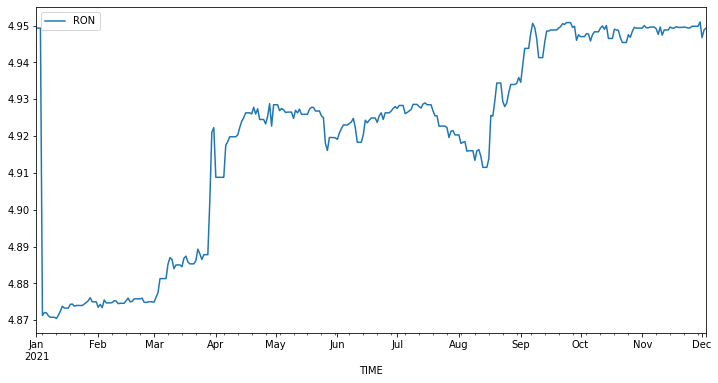

In [98]:
df.plot()

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose

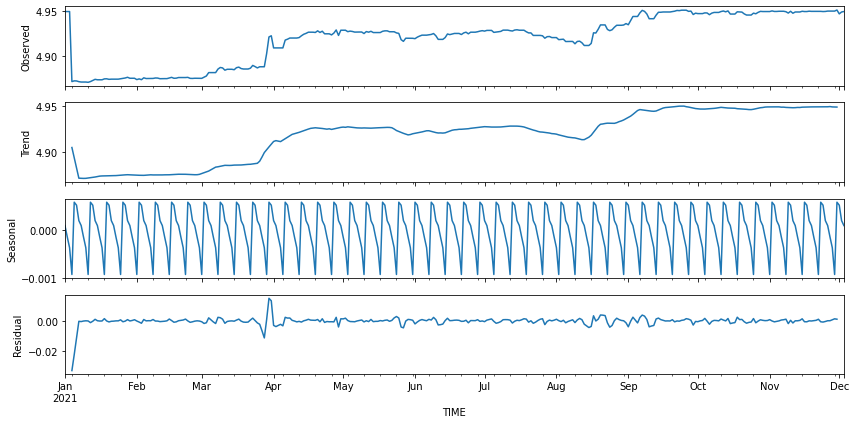

In [100]:
results = seasonal_decompose(df['RON'])
results.plot();

In [101]:
len(df)

337

In [102]:
train = df.iloc[:274]
test = df.iloc[274:]

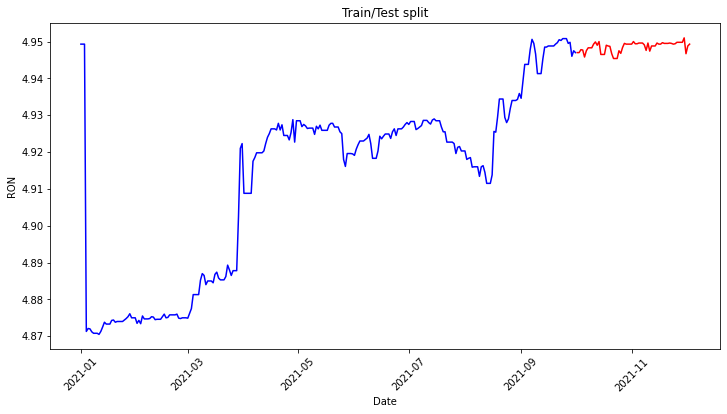

In [103]:
plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(train['RON'], color = "blue")
plt.plot(test['RON'], color = "red")
plt.ylabel('RON')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split")
plt.show()

In [104]:
#preprocesarea datelor, reducerea lor in intervalul [0, 1]
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [105]:
df.head(),df.tail()

(               RON
 TIME              
 2021-01-01  4.9493
 2021-01-02  4.9493
 2021-01-03  4.9493
 2021-01-04  4.8713
 2021-01-05  4.8721,                RON
 TIME              
 2021-11-29  4.9498
 2021-11-30  4.9510
 2021-12-01  4.9467
 2021-12-02  4.9488
 2021-12-03  4.9493)

In [106]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [107]:
scaled_train[:10]

array([[0.98132005],
       [0.98132005],
       [0.98132005],
       [0.00996264],
       [0.01992528],
       [0.01867995],
       [0.00871731],
       [0.00373599],
       [0.00373599],
       [0.00373599]])

In [108]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [109]:
# define generator
n_input = 30
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [110]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.98132005 0.98132005 0.98132005 0.00996264 0.01992528 0.01867995
 0.00871731 0.00373599 0.00373599 0.00373599 0.         0.00996264
 0.0249066  0.04109589 0.03486924 0.03486924 0.03486924 0.04732254
 0.04856787 0.04109589 0.04358655 0.04358655 0.04358655 0.04358655
 0.04856787 0.05354919 0.05977584 0.06973848 0.05603985 0.05603985]
Predict this y: 
 [[0.05603985]]


In [111]:
X.shape

(1, 30, 1)

In [112]:
n_input = 30
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [113]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [114]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [115]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [116]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
244/244 [==============================] - 5s 16ms/step - loss: 0.0214
Epoch 2/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0049
Epoch 3/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0036
Epoch 4/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0038
Epoch 5/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0030
Epoch 6/50
244/244 [==============================] - 4s 16ms/step - loss: 0.0027
Epoch 7/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0026
Epoch 8/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0024
Epoch 9/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0024
Epoch 10/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0023
Epoch 11/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0025
Epoch 12/50
244/244 [==============================] - 4s 15ms/step - loss: 0.0021
Epoch 13/50
2

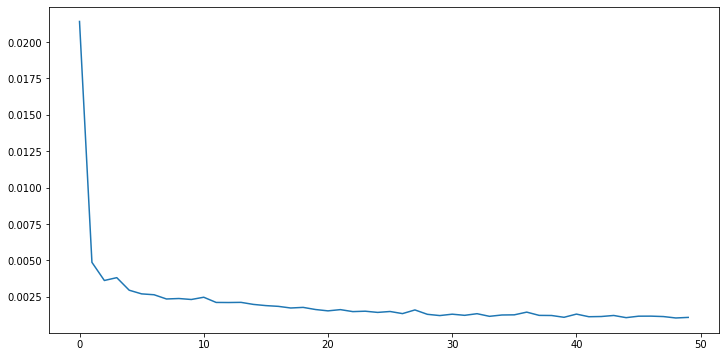

In [117]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [118]:
last_train_batch = scaled_train[-30:]

In [119]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [120]:
model.predict(last_train_batch)

array([[0.9326637]], dtype=float32)

In [121]:
scaled_test[0]

array([0.95267746])

In [122]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)



In [123]:
test_predictions

[array([0.9326637], dtype=float32),
 array([0.9119715], dtype=float32),
 array([0.8925786], dtype=float32),
 array([0.87417716], dtype=float32),
 array([0.85639733], dtype=float32),
 array([0.8390448], dtype=float32),
 array([0.822064], dtype=float32),
 array([0.8054572], dtype=float32),
 array([0.78926355], dtype=float32),
 array([0.77351105], dtype=float32),
 array([0.7582448], dtype=float32),
 array([0.74349934], dtype=float32),
 array([0.72931206], dtype=float32),
 array([0.71572113], dtype=float32),
 array([0.70274574], dtype=float32),
 array([0.6903961], dtype=float32),
 array([0.6786748], dtype=float32),
 array([0.6675797], dtype=float32),
 array([0.65710074], dtype=float32),
 array([0.6472266], dtype=float32),
 array([0.6379392], dtype=float32),
 array([0.6292228], dtype=float32),
 array([0.6210539], dtype=float32),
 array([0.6134119], dtype=float32),
 array([0.60626906], dtype=float32),
 array([0.5996079], dtype=float32),
 array([0.5933965], dtype=float32),
 array([0.5876188],

In [124]:
test.head()

,RON
TIME,
2021-10-02,4.9470
2021-10-03,4.9470
2021-10-04,4.9478
2021-10-05,4.9477
2021-10-06,4.9458


In [125]:
true_predictions = scaler.inverse_transform(test_predictions)

In [126]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


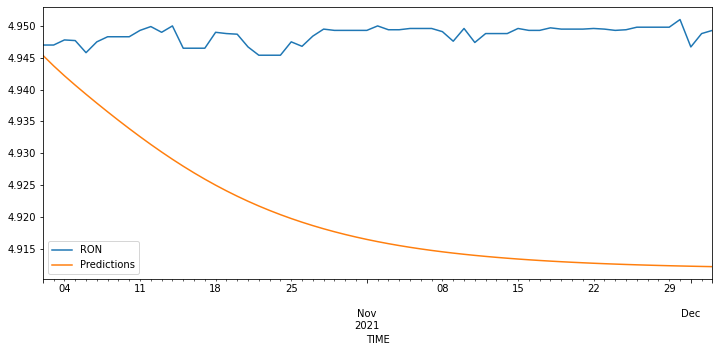

In [127]:
test.plot(figsize=(12,5))

In [128]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['RON'],test['Predictions']))
print(rmse)

0.02985196780386588
